In [9]:
# ==============================
# 1. Imports
# ==============================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sns.set(style="whitegrid")


In [10]:
# ==============================
# 2. Load Dataset
# ==============================
ds = load_dataset("hpe-ai/medical-cases-classification-tutorial")

train_df = ds["train"].to_pandas()
val_df   = ds["validation"].to_pandas()
test_df  = ds["test"].to_pandas()

# Combine all sets for clustering
df = pd.concat([train_df, val_df, test_df], ignore_index=True)
print("Total samples:", df.shape[0])
df.head()


Repo card metadata block was not found. Setting CardData to empty.


Total samples: 2464


,description,transcription,sample_name,medical_specialty,keywords
0,Pacemaker ICD interrogation. Severe nonischem...,"PROCEDURE NOTE: , Pacemaker ICD interrogation....",Pacemaker Interrogation,Cardiovascular / Pulmonary,"cardiovascular / pulmonary, cardiomyopathy, ve..."
1,"Erythema of the right knee and leg, possible s...","PREOPERATIVE DIAGNOSES: , Erythema of the righ...",Aspiration - Knee Joint,Orthopedic,"orthopedic, knee and leg, anterolateral portal..."
2,Left cardiac catheterization with selective ri...,"PREOPERATIVE DIAGNOSIS: , Post infarct angina....",Cardiac Cath & Selective Coronary Angiography,Cardiovascular / Pulmonary,"cardiovascular / pulmonary, selective, angiogr..."
3,Patient with a history of coronary artery dise...,"REASON FOR VISIT: , Acute kidney failure.,HIST...",Acute Kidney Failure,Nephrology,None
4,Cardiac evaluation and treatment in a patient ...,"REASON FOR REFERRAL: , Cardiac evaluation and ...",Cardiac Consultation - 6,Cardiovascular / Pulmonary,None


In [11]:
# ==============================
# 3. TF-IDF Vectorization
# ==============================
tfidf = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    ngram_range=(1,2),
    max_features=20000
)

X = tfidf.fit_transform(df["transcription"].fillna(""))
print("TF-IDF matrix shape:", X.shape)


TF-IDF matrix shape: (2464, 20000)


k=5, silhouette=0.0199
k=8, silhouette=0.0233
k=10, silhouette=0.0261
k=13, silhouette=0.0272
k=15, silhouette=0.0303


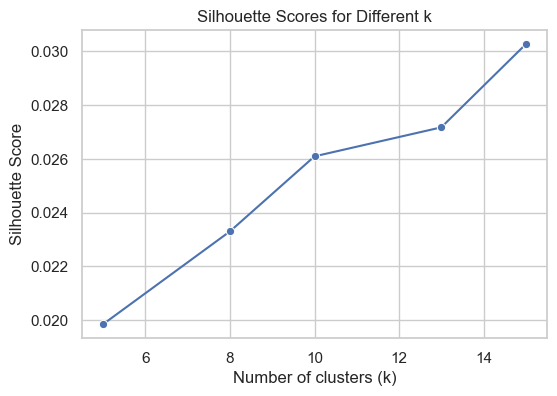

In [12]:
# ==============================
# 4. Silhouette Scores for Different k
# ==============================
scores = {}
for k in [5, 8, 10, 13, 15]:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    score = silhouette_score(X, labels)
    scores[k] = score
    print(f"k={k}, silhouette={score:.4f}")

# Plot scores
plt.figure(figsize=(6,4))
sns.lineplot(x=list(scores.keys()), y=list(scores.values()), marker="o")
plt.title("Silhouette Scores for Different k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()


In [13]:
# ==============================
# 5. Final k-Means Clustering (k=13)
# ==============================
k = 13
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X)

print("Cluster assignments complete ✅")
df[["transcription", "cluster"]].head()


Cluster assignments complete ✅


,transcription,cluster
0,"PROCEDURE NOTE: , Pacemaker ICD interrogation....",7
1,"PREOPERATIVE DIAGNOSES: , Erythema of the righ...",5
2,"PREOPERATIVE DIAGNOSIS: , Post infarct angina....",8
3,"REASON FOR VISIT: , Acute kidney failure.,HIST...",1
4,"REASON FOR REFERRAL: , Cardiac evaluation and ...",10


In [14]:
# ==============================
# 6. Top Terms per Cluster
# ==============================
terms = tfidf.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

print("\nTop terms per cluster:")
for i in range(k):
    top_terms = [terms[ind] for ind in order_centroids[i, :15]]
    print(f"Cluster {i}: {', '.join(top_terms)}")



Top terms per cluster:
Cluster 0: c5, c6, c4, c5 c6, cervical, c4 c5, c3, c7, c6 c7, c3 c4, anterior, anterior cervical, disc, disk, plate
Cluster 1: mg, daily, mg daily, patient, day, history, mg day, disease, discharge, dr, 20 mg, 10, heart, 40 mg, 20
Cluster 2: l5, l4, l4 l5, s1, l5 s1, lumbar, disc, nerve root, l3, root, disk, nerve, space, l3 l4, left
Cluster 3: patient, history, normal, discharge, examination, clear, mom, time, past, noted, pain, respiratory, mg, medications, does
Cluster 4: placed, patient, incision, procedure, closed, using, vicryl, uterus, anesthesia, fetal, right, fascia, suture, fashion, removed
Cluster 5: knee, tendon, medial, fracture, patient, placed, lateral, joint, right, foot, tourniquet, left, metatarsal, procedure, tear
Cluster 6: stress, heart rate, rate, heart, perfusion, exercise, beats, resting, test, minute, beats minute, predicted, myocardial perfusion, blood pressure, myocardial
Cluster 7: eye, catheter, vein, lead, procedure, placed, chamber

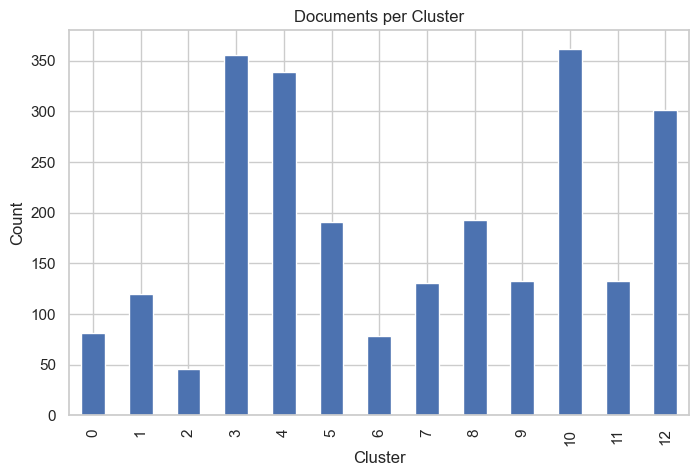

In [15]:
# ==============================
# 7. Cluster Distribution
# ==============================
plt.figure(figsize=(8,5))
df["cluster"].value_counts().sort_index().plot(kind="bar")
plt.title("Documents per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()
